# Sensor Fusion ND: 3D Object Tracking Report

## Project Overview

This notebook represents the final report of the project. It describes the implementation of the missing parts in the schematic:

<img src="../images/course_code_structure.png" width="779" height="414" />

Four major tasks are completed in the project and described below:
 1. First, **3D objects are matched over time** by using keypoint correspondences.
 2. Second, the **TTC based on Lidar** measurements is computed.
 3. Next the **TTC based on the camera** is computed, which requires to first associate keypoint matches to regions of interest and then to compute the TTC based on those matches. 
 4. And lastly, the **performance of the algorithms is analyzed** in various tests. The most suitable detector/descriptor combination for TTC estimation is identified and problems that can lead to faulty measurements by the camera or Lidar sensor are identified. 
 
See the [Rubric](https://review.udacity.com/#!/rubrics/2550/view) for detailed project requirements.

---

# Code Overview

## Basic Build Instructions

1. Clone this repo.
2. Make a build directory in the top level project directory: `mkdir build && cd build`
3. Compile: `cmake .. && make`
4. Run it: `./3D_object_tracking`.

## Usage

As in the midterm project I added a minimalist command line interface to perform the tasks FP.5/FP.6 efficiently.

Command line interface:
```bash
3D_object_tracking.exe [detector:0-7] [descriptor:0-6] [visualize:0-15]
```

where:
```C++
static array<string, 7> detectorTypes{"SHITOMASI", "HARRIS", "FAST", "BRISK", "ORB", "AKAZE", "SIFT"};
static array<string, 6> descriptorTypes{"BRISK", "BRIEF", "ORB", "FREAK", "AKAZE", "SIFT"};

enum VisFlags
{
    None = 0,
    Yolo = 1, TopView = 2, CameraView = 4, KeypointMatches = 8,
    All = Yolo | TopView | CameraView | KeypointMatches
};
```


## FP.1 : Match 3D Objects

### Task
*In this task, please implement the method "matchBoundingBoxes", which takes as input both the previous and the current data frames and provides as output the ids of the matched regions of interest (i.e. the boxID property)“. Matches must be the ones with the highest number of keypoint correspondences.*

### Solution

Code in method `matchBoundingBoxes`

The solution is based on a voting scheme. Each match between points votes for the corresponding bounding box pairs which are hit by the point coordinates.<br>
In the current implementation the vote is incremented by one, but may be weighted by quality measures like the distance or descriptor strength.

The following code fragment shows the loop over the matches, and the vote increment for their pair of boxes, iff the points are inside the bounding boxes:
```C++
    for (auto m : matches)
        for (auto y = 0; y < boxes_prev.size(); ++y)
            for (auto x = 0; x < boxes_curr.size(); ++x)
                if (boxes_prev[y].roi.contains(prevFrame.keypoints[m.queryIdx].pt) &&
                    boxes_curr[x].roi.contains(currFrame.keypoints[m.trainIdx].pt)) 
                    votes.at<int>(y, x)++;
```
After that a one-to-one correspondence is build by selecting successively the pair with the highest votes.
These box pair is added to the result `bbBestMatches` and both boxes are removed from the list of available boxes by resetting their votes to 0. See method `matchBoundingBoxes` for details.

## FP.2 : Compute Lidar-based TTC

### Task
*In this part of the final project, your task is to compute the time-to-collision for all matched 3D objects based on Lidar measurements alone. Please take a look at the "Lesson 3: Engineering a Collision Detection System" of this course to revisit the theory behind TTC estimation. Also, please implement the estimation in a way that makes it robust against outliers which might be way too close and thus lead to faulty estimates of the TTC. Please return your TCC to the main function at the end of computeTTCLidar.<br>
The task is complete once the code is functional and returns the specified output. Also, the code is able to deal with outlier Lidar points in a statistically robust way to avoid severe estimation errors.*

### Solution (see Lesson 3.2)

Code in method `computeTTCLidar`.

The time-to-collision (TTC) is based on the distance to the car, more precisely on the lidar points on the tail of the car.
In order to derive a **stable** TTC measurement from given point cloud, the following steps should be performed:
 * Remove measurements on the road surface (done by method `cropLidarPoints`)
 * Remove measurements with low reflectivity (not implemented)
 * Remove noisy measurements close to ego vehicle (implemented in `computeTTCLidar`)

To filter the Lidar measurements in a statistically robust way, only those measurements are used for the approximation of the min distance which are in a certain quantile of the x distribution. This measurement is more robust as a single point, but it may have a small bias, because it is not just the closest point that determines the TTC.
```C++
// More robust x-min point selection by using 5%-30% quantile to remove single noisy points (see top view)
double quantileMin = 0.05;
double quantileMax = 0.30;
double minXPrev = computeMeanInQuantile(lidarPointsPrev, quantileMin, quantileMax);
double minXCurr = computeMeanInQuantile(lidarPointsCurr, quantileMin, quantileMax);

// compute TTC from both measurements
double dT = 1.0 / frameRate; // time between two measurements in seconds
TTC = minXCurr * dT / (minXPrev - minXCurr);
```
The computation of the mean X quantile is implemented in the helper method `computeMeanInQuantile`.


An alternative solution may be to remove outliers fist, e.g. using the mean/variance of the x distribution, instead of using a fixed portion of the data. Additional filtering  using a-priori knowledge like a predefined lane width as discussed in lesson 3.2 ["Estimating TTC with Lidar"](https://classroom.udacity.com/nanodegrees/nd313/parts/1971021c-523b-414c-93a3-2c6297cf4771/modules/3eb3ecc3-b73d-43bb-b565-dcdd5d7a2635/lessons/dfe71db5-4233-4e4f-b33f-40cb9899dc13/concepts/c78c2068-ff3b-4146-9f1f-77ea44188ef2) may be useful.

# Compute Camera-based TTC

The YOLO object detector has extracted a number of bounding boxes for the different objects in the scene. This includes a class label and a confidence value.

<img src="report-YOLO-classification.png" />

The $TTC_{camera}$ computation is done for each object in two steps:
 1. All enclosed keypoint matches are assigned to the bounding box (FP.3)
 2. Time-to-collision is computed based on the keypoints in a box (FP.4)

## FP.3 : Associate Keypoint Correspondences with Bounding Boxes

### Task
*Before a TTC estimate can be computed in the next exercise, you need to find all keypoint matches that belong to each 3D object. You can do this by simply checking whether the corresponding keypoints are within the region of interest in the camera image. All matches which satisfy this condition should be added to a vector. The problem you will find is that there will be outliers among your matches. To eliminate those, I recommend that you compute a robust mean of all the euclidean distances between keypoint matches and then remove those that are too far away from the mean.<br>
The task is complete once the code performs as described and adds the keypoint correspondences to the "kptMatches" property of the respective bounding boxes. Also, outlier matches have been removed based on the euclidean distance between them in relation to all the matches in the bounding box.*

### Solution

Code in method `clusterKptMatchesWithROI`.

Typically all matches on an object at a certain distance from the camera should have a similar direction vector, e.g. a radial optical flow field when approaching a target in front. Therefore the length of this vectors (distances) should be similar.

To filter out mismatches, euclidean distances are computed:
```C++
vector<double> distances;
for (auto m : kptMatches)
    if (boundingBox.roi.contains(kptsCurr[m.trainIdx].pt)) 
        double d = cv::norm(kptsCurr[m.trainIdx].pt - kptsPrev[m.queryIdx].pt); // L2
        distances.push_back(d);
```
and outliers are discarded by a *z-score test*, a test which removes candidates with a distance outside the typical range (defined by mean/variance of the data):
```C++
    ComputeMeanStd(distances, mean, std);
    for (auto m : kptMatches)
        ...
        if (fabs(d - mean) <= 3 * std) // 99.7% of normal distribution
        {
            boundingBox.kptMatches.push_back(m);
```

Outlier removal by [Median Absolute Deviation (MAD)](https://hausetutorials.netlify.app/posts/2019-10-07-outlier-detection-with-median-absolute-deviation) has also been implemented, which in theory is more robust to outliers than the z-score filtering. However, given the data, it doesn't make much difference. 

```C++
    ComputeMedianAbsoluteDeviation(distances, median, mad);
    for (auto m : kptMatches)
        ...
        if (fabs(dist - median) <= 5 * mad)
        {
            boundingBox.kptMatches.push_back(m);
```

## FP.4 : Compute Camera-based TTC

### Task
*Once keypoint matches have been added to the bounding boxes, the next step is to compute the TTC estimate. As with Lidar, we already looked into this in the second lesson of this course, so you please revisit the respective section and use the code sample there as a starting point for this task here. Once you have your estimate of the TTC, please return it to the main function at the end of computeTTCCamera.<br>
The task is complete once the code is functional and returns the specified output. Also, the code must be able to deal with outlier correspondences in a statistically robust way to avoid severe estimation errors.*

### Solution (see Lesson 3.3)

Code in method `computeTTCCamera`.

The code is based on the exercise in lesson 3.3 ["Estimating TTC with Camera"](https://classroom.udacity.com/nanodegrees/nd313/parts/1971021c-523b-414c-93a3-2c6297cf4771/modules/3eb3ecc3-b73d-43bb-b565-dcdd5d7a2635/lessons/dfe71db5-4233-4e4f-b33f-40cb9899dc13/concepts/daceaff3-1519-4f4c-82ff-16e02b5c2e8f), the mean distance ratio of all keypoint matches is used to estimate the TTC.

```C++
std::sort(distRatios.begin(), distRatios.end());
int n_2 = int(distRatios.size() / 2);
double medianDistRatio = distRatios.size()%2==1 ? 
       distRatios[n_2] : (distRatios[n_2-1]+dRatios[n_2])/2;

TTC = -dT / (1 - medianDistRatio);
```

# Performance Evaluation

When starting the program in the command line (see *Usage* above) via
```bash
3D_object_tracking.exe [detector:0-7] [descriptor:0-6] [visualize:0-7]
```
various performance characteristics are logged into CSV files with the filename pattern `run.{detectorType}.{descriptorType}.csv`.

For example, the following plot shows $TTC_{camera}$ and $TTC_{lidar}$ predictions for the `car` object in the KITTI sequence logged in `run.SHITOMASI.BRISK.csv`. The raw data are filtered by the class label ID of the object which is provided by the YOLO detector.

<img src="report-plot-timeline.png" width=400/>
<br/>
<img src="kitty-sequence.gif" width=400/>

Note: The plot and movie is generated by notebook cells below.

## FP.5 : Performance Evaluation LIDAR

### Task
*This exercise is about conducting tests with the final project code, especially with regard to the Lidar part. Look for several examples where you have the impression that the Lidar-based TTC estimate is way off. Once you have found those, describe your observations and provide a sound argumentation why you think this happened.*

*The task is complete once several examples (2-3) have been identified and described in detail. The assertion that the TTC is off should be based on manually estimating the distance to the rear of the preceding vehicle from a top view perspective of the Lidar points.*

### Solution

#### LIDAR Example 1

Obviously, the $TT_{lidar}$ computation in the back course of the timeline plot is no longer correct (Frame #52 and above).
This can be explained by the fact that the car is stationary and therefore the TTC is infinite.
Depending on the noise in the data, the TTC value jumps from minus to plus infinity, caused by the noisy eps in the denominator:
```C++
TTC = minXCurr * dT / (minXPrev - minXCurr);
```
Since the ego motion is known in a real world szenario, this case can be easily recognized. 

#### LIDAR Example 2

Another artifact can be observed in image pair 2/3 (first lidar peak). The $TT_{lidar}$ estimation is 22 sec and way of from the camera measurement and and from neighboring measurements.

The top view of the lidar point cloud seems to be ok:

<img src="report-lidar-2x3-top.png" width=800/>

But viewed from the camera perspective, it can be observed that a larger number of points are now recorded below the bumper, which are further away. This may be a reason for the higher TTC value, because as discussed in section FP.2, not a single noisy point is used for TTC computation but a subset (quantile) of the x-distribution. In this case a few samples of these points may be used for the computation, which will increase the approximated x-distance and therefor the TTC.

<img src="report-lidar-2x3-camera.png" width=600/>

#### LIDAR Example 3

The following two plots show other lidar measurements artifacts which are successfully filtered.

Frame #10 shows a single noisy measurements in front of the car, which would have affected the naive measurement:

<img src="report-lidar-10-noise.png" width=400 />

Frame #27 shows lidar measurement outliers taken from the rearview mirror of the car:

<img src="report-lidar-27-mirror.png" width=400 />

#### LIDAR Example 4

Starting with Frame #48 the system reports other incorrect TTC lidar measurements. From this point the YOLO rectangle of the truck intersects with the rectangle of the car and some of the cropped lidar points are also assigned to the bounding box of the truck, which triggers the TTC computation.

<img src="report-lidar-48-camera.png" width=400/>

## FP.6 : Performance Evaluation CAMERA
### Task
*This last exercise is about running the different detector / descriptor combinations and looking at the differences in TTC estimation. Find out which methods perform best and also include several examples where camera-based TTC estimation is way off. As with Lidar, describe your observations again and also look into potential reasons. This is the last task in the final project.*

*The task is complete once all detector / descriptor combinations implemented in previous chapters have been compared with regard to the TTC estimate on a frame-by-frame basis. To facilitate the comparison, a spreadsheet and graph should be used to represent the different TTCs.*

### Solution

To analyze the performance of the camera-based TTC estimation and find examples where the estimation failed, the (visualization) code of the midterm project is added, but now the shown matches are restricted to the bounding boxes computed by `matchBoundingBoxes` (FP.1).

To analyze the different detector / descriptor combinations, all CVS logfiles are generated by the script [run_all.sh](../run_all.sh) first:

```bash
for detector in {0..6} do
	for descriptor in {0..5} do
	./3D_object_tracking $detector $descriptor 0
	done
done
```

The data is loaded in the following cells and stored in a (detector, descriptor)-based dictionary `tables`.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
cm = sns.light_palette("red", as_cmap=True)

In [2]:
tables = {}

#for file in Path("./runs.local").glob("*.csv"):
for file in Path("./runs.udacity").glob("*.csv"):
    
    # split 'run.AKAZE.AKAZE.csv'
    detector, descriptor = file.name.split(".")[1:3]

    df = pd.read_csv(file, sep=",", na_values=["-inf","inf","nan(ind)","-nan(ind)"])
    df.set_index("image", inplace=True)
    tables[(detector, descriptor)] = df
    
print("Available (detector, descriptor) combinations:", [key for key in tables.keys()])

Available (detector, descriptor) combinations: [('AKAZE', 'AKAZE'), ('AKAZE', 'BRIEF'), ('AKAZE', 'BRISK'), ('AKAZE', 'FREAK'), ('AKAZE', 'ORB'), ('AKAZE', 'SIFT'), ('BRISK', 'BRIEF'), ('BRISK', 'BRISK'), ('BRISK', 'FREAK'), ('BRISK', 'ORB'), ('BRISK', 'SIFT'), ('FAST', 'BRIEF'), ('FAST', 'BRISK'), ('FAST', 'FREAK'), ('FAST', 'ORB'), ('FAST', 'SIFT'), ('HARRIS', 'BRIEF'), ('HARRIS', 'BRISK'), ('HARRIS', 'FREAK'), ('HARRIS', 'ORB'), ('HARRIS', 'SIFT'), ('ORB', 'BRIEF'), ('ORB', 'BRISK'), ('ORB', 'FREAK'), ('ORB', 'ORB'), ('ORB', 'SIFT'), ('SHITOMASI', 'BRIEF'), ('SHITOMASI', 'BRISK'), ('SHITOMASI', 'FREAK'), ('SHITOMASI', 'ORB'), ('SHITOMASI', 'SIFT'), ('SIFT', 'BRIEF'), ('SIFT', 'BRISK'), ('SIFT', 'FREAK'), ('SIFT', 'SIFT')]


The TTC has been estimated on a frame-by-frame basis, as shown next in the table (SHITOMASI, BRISK combination):

In [3]:
tables[("SHITOMASI","BRISK")].T

image,1,2,3,4,5,6,7,8,9,10,...,72,73,73,74,74,75,75,76,76,77
class_id,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,2.0000,...,7.0000,2.000,7.0000,2.000,7.00000,2.00,7.00000,2.00,7.0000,2.000000
ttcLidar,14.6099,10.3291,32.3865,13.3166,11.5447,12.4463,11.6265,15.9386,12.2729,12.9956,...,1.5423,253.032,30.0217,450.786,-1.55124,1012.47,1.45615,-145.13,-40.7271,-0.155063
ttcCamera,12.8228,12.6968,14.4793,12.7779,12.4657,14.0207,12.7924,13.2285,11.7376,12.0439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lidar_points,338.0000,305.0000,321.0000,319.0000,340.0000,345.0000,315.0000,307.0000,302.0000,278.0000,...,12.0000,422.000,13.0000,409.000,14.00000,426.00,12.00000,437.00,10.0000,13.000000
camera_matches,50.0000,50.0000,42.0000,53.0000,50.0000,48.0000,58.0000,48.0000,53.0000,53.0000,...,357.0000,155.000,358.0000,159.000,341.00000,161.00,349.00000,171.00,356.0000,148.000000


The following figure shows the timeline of TTC estimations for all detector / descriptor combinations. The sequence is restricted to the non stationary part of the sequence (frames 0-45).

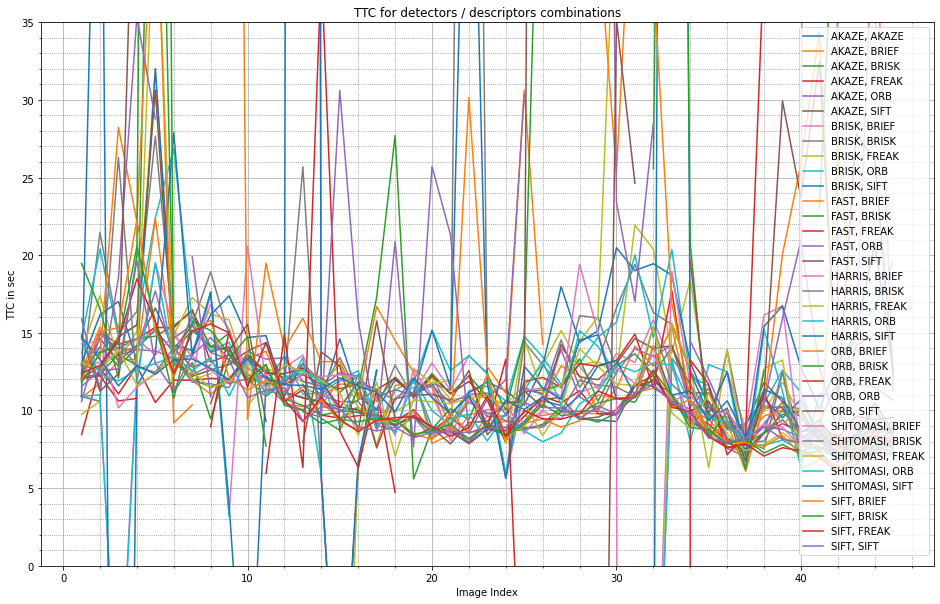

In [4]:
imgStartIndex = 0
imgEndIndex = 45

def plot_ttc(keys, ylim=None):
    plt.figure(figsize=(16,10))
    plt.title("TTC for detectors / descriptors combinations")

    for key in keys:
        df = tables[key][imgStartIndex: imgEndIndex]
        detector, descriptor = key
        plt.plot(df["ttcCamera"], label=f"{detector}, {descriptor}")
    if ylim:
        plt.ylim(ylim)
    plt.xlabel("Image Index")
    plt.ylabel("TTC in sec")
    plt.grid(which="major", linestyle='-')
    plt.grid(which="minor", linestyle=':', color="gray")
    plt.minorticks_on()
    plt.legend(loc="upper right")
    plt.show()

all_keys = tables.keys()
plot_ttc(all_keys, ylim=(0,35))

#### TTCs Quality Metrics

To assess the quality of a combination, two quality criteria are defined and examined:

 1. Given a sequence of alternative TTC computations (lidar/camera), the corresponding values are expected to match. A simple measure for this is the Mean Absolute Error (MAE) between $TTC_{lidar}$ and $TTC_{camera}$:

$$ MAE = \frac{1}{\#frames} \sum_{frames}{|TTC_{lidar} - TTC_{camera}|} $$

 2. Another expectation about the series of $TTC_{camera}$ measurements is the smoothness of the curve. With constant breaking of the car, the values should not jump back and forth too much. A simple measure for this is the Mean Absolute Differences (MAD) of successive measurements:

$$ MAD = \frac{1}{\#frames-1} \sum_{frames}{|TTC_{camera}(frame_{i+1}) - TTC_{camera}(frame_i) |} $$

The following table shows the two metics for all possible combinations of detectors and descriptors. The column *MAE* shows the mean difference between the Lidar and Camera TTC.

In [5]:
table = {
    "Detector" : [],
    "Descriptor" : [],
    "MAE" : [],
    "MAD" : []
}
         
for (detector, descriptor) in tables.keys():
    table["Detector"].append(detector)
    table["Descriptor"].append(descriptor)
    
    df = tables[(detector, descriptor)][imgStartIndex: imgEndIndex]
    # compute mean diff, ignoring nans
    mae = np.nanmean(np.abs( df["ttcLidar"] - df["ttcCamera"]) )
    table["MAE"].append(mae)
    mad = np.nanmean(np.abs( np.diff(df["ttcCamera"])) )
    table["MAD"].append(mad)

df = pd.DataFrame(table).sort_values(by="MAE").reset_index(drop=True)
df.style.set_caption('Combinations ranked by Mean Absolute Error (MAE)').background_gradient(cmap=cm)

,Detector,Descriptor,MAE,MAD
0,SIFT,FREAK,2.025712,1.271053
1,AKAZE,BRISK,2.092991,0.836311
2,AKAZE,BRIEF,2.093537,1.051734
3,SIFT,BRISK,2.146832,1.217636
4,SIFT,SIFT,2.159467,1.039399
5,AKAZE,ORB,2.175838,0.982110
6,AKAZE,AKAZE,2.191004,0.953603
7,SIFT,BRIEF,2.198083,1.536822
8,SHITOMASI,ORB,2.274799,1.228853
9,SHITOMASI,BRISK,2.275929,1.077025


In [6]:
df = pd.DataFrame(table).sort_values(by="MAD").reset_index(drop=True)
df.style.set_caption('Combination ranked Mean Absolute Differences (MAD)').background_gradient(cmap=cm)

,Detector,Descriptor,MAE,MAD
0,AKAZE,BRISK,2.092991,0.836311
1,AKAZE,FREAK,2.371326,0.904194
2,AKAZE,AKAZE,2.191004,0.953603
3,AKAZE,ORB,2.175838,0.982110
4,AKAZE,SIFT,2.392158,0.983968
5,SIFT,SIFT,2.159467,1.039399
6,AKAZE,BRIEF,2.093537,1.051734
7,SHITOMASI,BRISK,2.275929,1.077025
8,SHITOMASI,SIFT,2.692755,1.192777
9,SIFT,BRISK,2.146832,1.217636


#### Top 3 combinations (MAD metric)

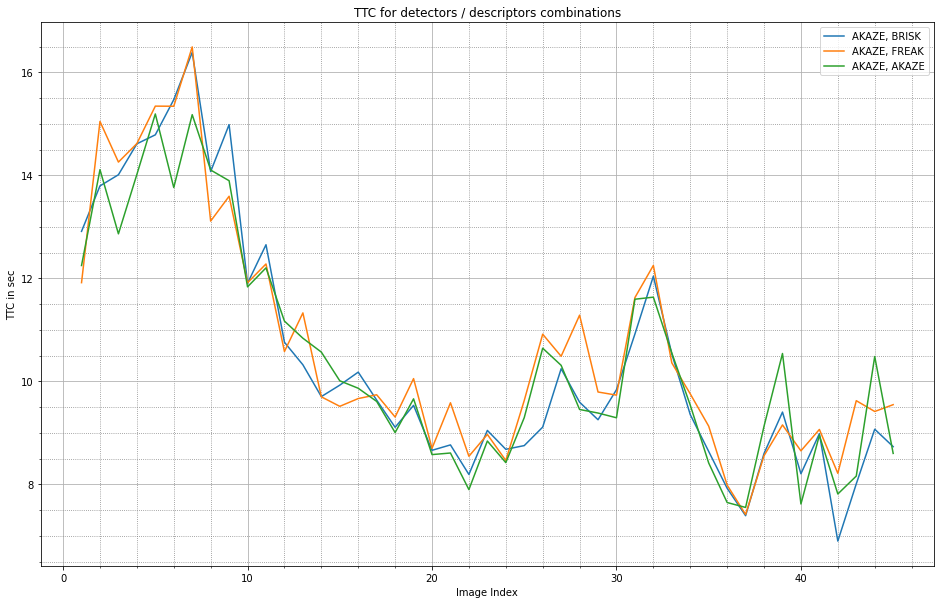

In [7]:
best_combinations = [(row["Detector"], row["Descriptor"]) for i,row in df[:3].iterrows()]

plot_ttc(best_combinations)

#### Worst 5 combinations (both metrics)

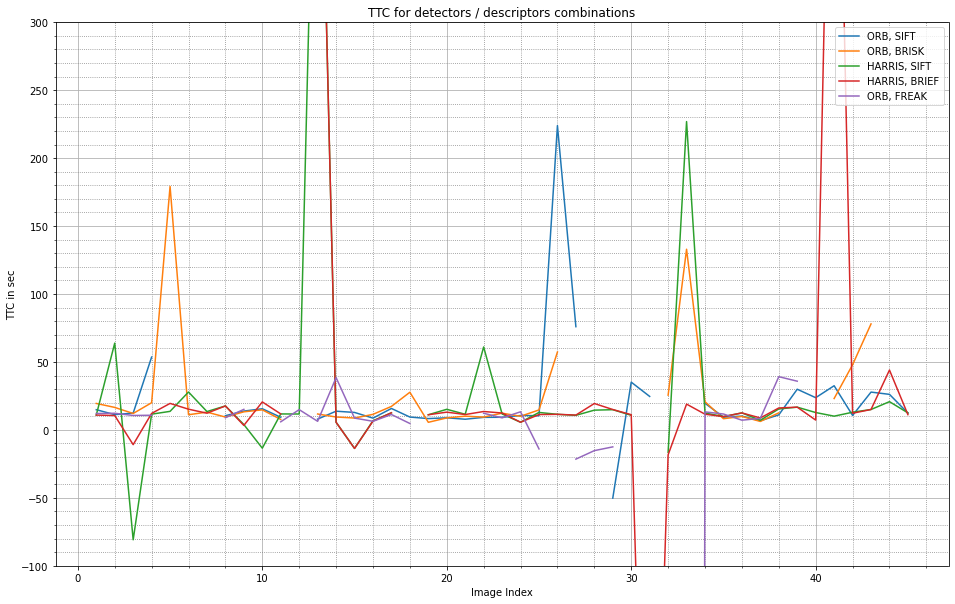

In [8]:
worst_combinations = [(row["Detector"], row["Descriptor"]) for i,row in df[-5:].iterrows()]

plot_ttc(worst_combinations, ylim=(-100,300))

Let's have a look at a few examples where camera-based TTC estimation is way off:

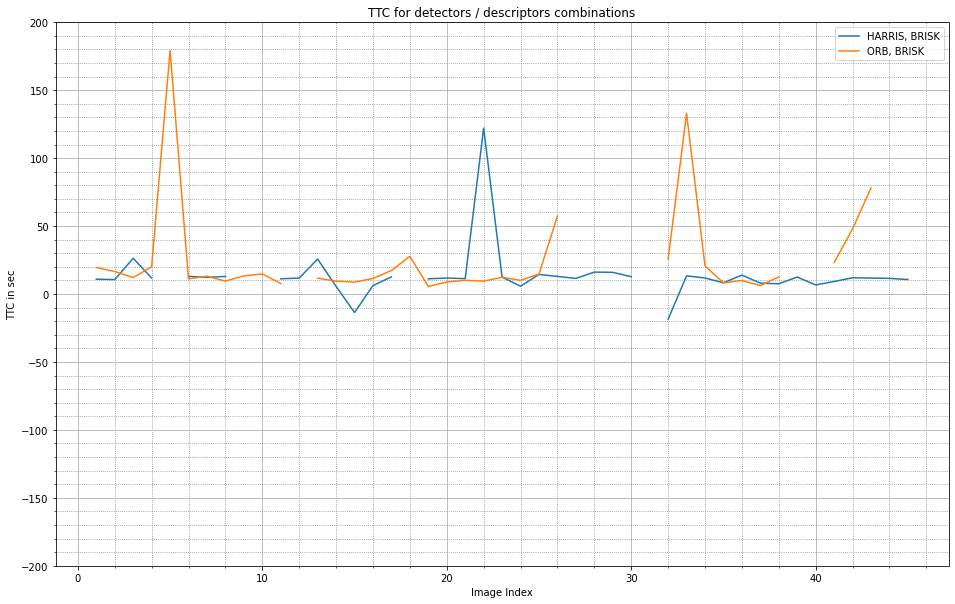

In [9]:
selected_combinations = (
    ("HARRIS", "BRISK"), 
    ("ORB", "BRISK"),
)
plot_ttc(selected_combinations, ylim=(-200,200))

#### Camera Example 1

The (HARRIS, BRISK) curve shows a peak at frame #22, measuring a TTC of more than 122 seconds.

<img src="ttc_camera-22-wrong_car.png" width=810 />

There are only 8 matches found inside the box, and 3 of them are on cars further away. Since none of the pairs were classified as outliers, the mean keypoint distance is strongly influenced by other cars.

#### Camera Example 2

Same in (ORB, BRISK) curve at frame #33, TTC is ~180.

<img src="ttc_camera-33-wrong_car.png" width=810 />

#### Camera Example 3

Another observation in (ORB, BRISK) are many mission values, caused by a TTC of $\infty$, because in these frames non of the distances has changed, and therefore the denominator in the TTC formular $(1 - d_{curr}/d_{prev})$ is zero.

#### General Observations

This is related to a general problem: The **distances of all the matches are very small**. Mostly 0, 1 or sqrt(2) pixel. To get more reliable measurements the frame rate should be reduced (e.g. via `imgStepWidth`) or the camera resolution should be increased.

# Appendix A: Generation of figure in FP.5 

To analyse the full sequence the detection results of the truck has to be removed. This can be done by filtering the object class (car: 2 vs. truck: 7) provided by the YOLO detector.

See `class_id` in
```bash
head ./dat/yolo/coco.names
```

In [10]:
(detector, descriptor) = ("SHITOMASI","BRISK")

df = tables[(detector, descriptor)]
df = df[df.class_id==2][["ttcLidar", "ttcCamera"]]
df.T

image,1,2,3,4,5,6,7,8,9,10,...,68,69,70,71,72,73,74,75,76,77
ttcLidar,14.6099,10.3291,32.3865,13.3166,11.5447,12.4463,11.6265,15.9386,12.2729,12.9956,...,338.483,590.959,-1003.0,334.827,-192.909,253.032,450.786,1012.47,-145.13,-0.155063
ttcCamera,12.8228,12.6968,14.4793,12.7779,12.4657,14.0207,12.7924,13.2285,11.7376,12.0439,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


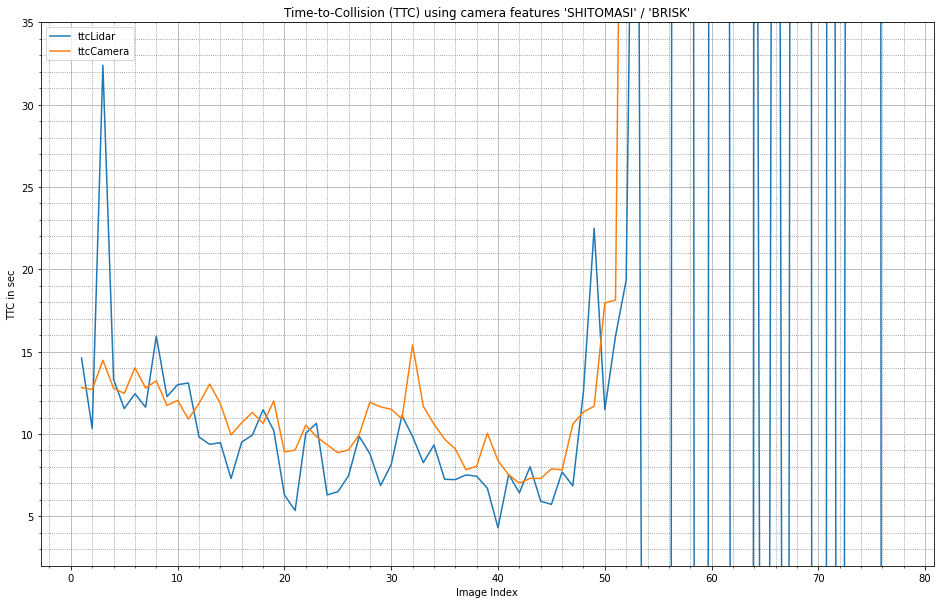

In [11]:
df.plot(figsize=(16,10))
plt.title(f"Time-to-Collision (TTC) using camera features '{detector}' / '{descriptor}'")
plt.xlabel("Image Index")
plt.ylabel("TTC in sec")
plt.ylim(2, 35)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color="gray")
plt.minorticks_on()
plt.show()

# Appendix B: Generation of video sequence

Animated GIF:

In [12]:
#https://pythonprogramming.altervista.org/png-to-gif
#https://www.kite.com/python/answers/how-to-add-label-text-to-an-image-in-python
from PIL import Image, ImageDraw

hz = 10
duration = 1000 / hz # display duration of each frame [ms]
source_size = (1242, 375)
target_size = (np.array(source_size)/3).astype(np.int)

imgs = Path("../images/KITTI/2011_09_26/image_02/data").glob("*.png")

# Create the frames
frames = []
for i, file in enumerate(imgs):
    img = Image.open(file).resize(target_size)
    draw = ImageDraw.Draw(img)
    draw.text((20,1), f"Frame {i}", fill=(255,0,0,255))
    frames.append(img)
    
# Save into a GIF file that loops forever
frames[0].save('kitty-sequence.gif', format='GIF', 
               append_images=frames[1:], save_all=True, duration=duration, loop=0)

<img src="kitty-sequence.gif" width=828 />